In [69]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline 


## **Разделим данные на тренировочные и тестовые и сделаем конвеер для первичной обработки**

In [42]:
df_class = pd.read_excel("data.xlsx")
train_class, test_class = train_test_split(df_class, test_size=0.3, random_state=42)

#### **Класс для создания классификационной переменной**

In [43]:
class CreateClasses(BaseEstimator, TransformerMixin):
    def __init__(self, SI_col='SI'):
        self.SI_col = SI_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["SI_class"] = X[self.SI_col] > 8
        return X

#### **Класс для рассчета Si**

In [44]:
class Calc_Si(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["SI"] = X["CC50, mM"] / X["IC50, mM"]
        return X

#### **Класс для удаления выбросов**

In [45]:
class Outliers_data(BaseEstimator, TransformerMixin):

    def __init__(self, target_cols, threshold=1000):
        self.columns =  target_cols #["IC50, mM", "SI"]
        self.threshold = threshold

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.filters_ = (X[self.columns] <= self.threshold).all(axis=1)
        return X[self.filters_].copy()

#### **Класс для логорифмирования целевой переменной**

In [46]:
class LogTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, replace_zero=1e-10):
        self.target_col = target_col
        self.replace_zero = replace_zero
    
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        X_transformed = X.copy()
        # Заменяем нули и логарифмируем
        X_transformed[self.target_col] = np.log(X[self.target_col].replace(0, self.replace_zero))
        return X_transformed

#### **Класс для удаления нулевых признаков**

In [47]:
class DropZeroData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop_ = None

    def fit(self, X, y=None):
        self.columns_to_drop_ = X.columns[X.sum() == 0].tolist()
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_)

#### **Класс для создания новых признаков**

In [48]:
class FeatureAggregator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):      
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Групповые суммы
        X_transformed['Hydrophilic_VSA'] = X[['SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3']].sum(axis=1)
        X_transformed['Moderate_VSA'] = X[['SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6']].sum(axis=1)
        X_transformed['Lipophilic_VSA'] = X[['SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA10']].sum(axis=1)
        X_transformed['frointier_VSA'] = X[['SlogP_VSA11', 'SlogP_VSA12']].sum(axis=1)
        
        # Разности
        X_transformed["DiffPartialCharge"] = X["MaxPartialCharge"] - X["MinPartialCharge"]
        X_transformed["DiffEStateIndex"] = X["MaxEStateIndex"] - X["MinEStateIndex"]
        
        return X_transformed

#### **Данные по матрице корреляции**

In [49]:
data_to_drop = ['fr_COO',
 'fr_COO2',
 'fr_Nhpyrrole',
 'fr_COO2',
 'fr_phenol_noOrthoHbond',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_C_O_noCOO',
 'fr_Al_OH_noTert',
 'fr_nitro_arom_nonortho',
 'fr_ketone_Topliss',
 'fr_halogen',
 'fr_NH0','BCUT2D_MRHI', 'BCUT2D_LOGPLOW', 'BCUT2D_LOGPHI']

### **Класс для отбора признаков**

In [50]:
class MutualInfoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='CC50, mM', threshold=0.1, random_state=42):
        self.target_col =target_col
        self.threshold = threshold
        self.random_state = random_state
        self.selected_features_ = None
        self.feature_importances_ = None
    
    def fit(self, X):
        y = X[self.target_col]
        X_mut = X.drop(columns = self.target_col) 
        # Вычисляем mutual information
        importances = mutual_info_regression(X_mut, y, random_state=self.random_state)
        
        # Сохраняем важность признаков
        self.feature_importances_ = pd.Series(importances, index=X_mut.columns)
        
        # Выбираем признаки, превышающие порог
        self.selected_features_ = self.feature_importances_[
            self.feature_importances_ >= self.threshold
        ].index.tolist()
        self.selected_features_.append(self.target_col)
        return self
    
    def transform(self, X):
        # Возвращаем только выбранные признаки

        return X[self.selected_features_]

### **Конвеер предобработки обработки данных**

In [51]:
preprocessing_pipeline = Pipeline([
    ('filter_data', Outliers_data(target_cols=["SI"])), # Класс для удаления выбросов
    ('calculate_si', Calc_Si()), # Класс для расчета Si
    ('Target and other median', CreateClasses()),
    ('drop Unnamed 0', FunctionTransformer(lambda df: df.drop(columns=["Unnamed: 0", "SI", 'IC50, mM', 'CC50, mM']))), # удаляем ненужные признаки
    ('drop_na', FunctionTransformer(lambda df: df.dropna())), #Удаляем строки с пропусками  
    ('drop_duplicates', FunctionTransformer(lambda df: df.drop_duplicates())), # Удаляем строки дубликаты
    ('drop Zero', DropZeroData()),
    ("create new feature", FeatureAggregator()),
    ('drop corr data', FunctionTransformer(lambda df: df.drop(columns=data_to_drop))),
    ('select feature', MutualInfoFeatureSelector(target_col='SI_class', threshold=0.05 ))
])

In [52]:
encode_train = preprocessing_pipeline.fit_transform(train_class)
encode_test = preprocessing_pipeline.transform(test_class)

 # **Выбор модели и подбор гиперпараметров**

### **Отразим распределение целевой переменной**

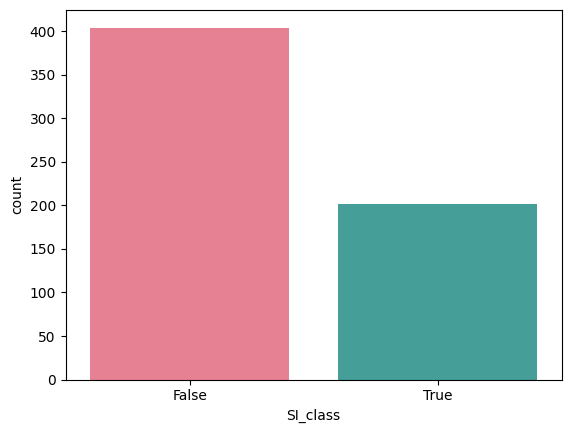

In [53]:
sns.countplot(x ='SI_class', data =  encode_train, hue='SI_class', palette="husl", legend=False)
plt.show()

### **Данные получились не сбалансированные, применим Adasyn для баланса на тренировочных данных**

In [54]:
# Выделим X и Y
y_train = encode_train['SI_class']
x_train = encode_train.drop(columns=['SI_class'])

y_test = encode_test['SI_class']
x_test = encode_test.drop(columns=['SI_class'])

In [55]:
# Создаем экземпляр ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=3)

# Применяем ADASYN
X_ADASYN, y_ADASYN = adasyn.fit_resample(x_train, y_train)

# Собираем всё обратно в DataFrame
balanced_df_ADASYN = pd.DataFrame(X_ADASYN, columns=x_train.columns)
balanced_df_ADASYN['SI_class'] = y_ADASYN

balanced_df_ADASYN['SI_class'].value_counts()

SI_class
True     415
False    404
Name: count, dtype: int64

### **Стандартизируем отобранные данные**

In [56]:
scaler = StandardScaler()
y_train = y_ADASYN
X_train = scaler.fit_transform(X_ADASYN)
X_test = scaler.transform(x_test)

### **Логистическая регрессия**

In [57]:
# Создаем модель логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Кросс-валидация на тренировочных данных
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print("Точность на каждом из фолдов:\n", cv_scores)
print("Средняя точность на кросс-валидации:", np.mean(cv_scores))

# Обучаем модель 
log_reg.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса

# Оценка качества на тестовых данных
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")

# Основные метрики классификации
print(f"Accuracy (Точность): {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Точность предсказаний): {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Полнота): {recall_score(y_test, y_pred):.4f}")
print(f"F1-score (F-мера): {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Точность на каждом из фолдов:
 [0.57317073 0.54268293 0.66463415 0.67073171 0.6196319 ]
Средняя точность на кросс-валидации: 0.6141702828071225

Метрики на тестовой выборке:
----------------------------------------
Accuracy (Точность): 0.5678
Precision (Точность предсказаний): 0.4046
Recall (Полнота): 0.5699
F1-score (F-мера): 0.4732
AUC-ROC: 0.5953


#### **Оценка метрик**

**Accuracy** (Точность): 0.5678 - Модель правильно предсказывает класс в 56.78% случаев

**Precision** (Точность предсказаний): 0.4046 - Из всех предсказанных положительных классов 40.46% действительно положительные

**Recall** (Полнота): 0.5699 - Модель находит 56.99% всех реальных положительных случаев и пропускает 43%

**F1-score** : 0.4732  - баланс между точностью и полнотой, средний результат(чем ближе к 1 тем лучше)

**ROC-AUC** : 0.5953 - Модель на 59.53% лучше случайного классификатора

### **Метод ближайших соседей KNN**

In [58]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skopt')

# Параметры для оптимизации
knn_params = {
    'n_neighbors': Integer(3, 100),
    'weights': ['uniform', 'distance'],
    'p': Integer(1, 5)  # 1 - манхэттен, 2 - евклидово
}

# Модель
knn_model = KNeighborsClassifier()

# Оптимизация
knn_search = BayesSearchCV(
    knn_model,
    knn_params,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Обучение
knn_search.fit(X_train, y_train)

# Вывод результатов
print("\nK-Nearest Neighbors")
print("Лучшие гиперпараметры:")
for key, val in knn_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = knn_search.predict(X_test)
y_proba = knn_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")



K-Nearest Neighbors
Лучшие гиперпараметры:
n_neighbors: 4
p: 1
weights: distance

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.6410
Precision: 0.4737
Recall: 0.4839
F1-score: 0.4787
AUC-ROC: 0.6571


#### **Оценка метрик**

**Accuracy** (Точность):  0.641- Модель правильно предсказывает класс в 64% случаев

**Precision** (Точность предсказаний): 0.4737- Из всех предсказанных положительных классов 47% действительно положительные

**Recall** (Полнота): 0.4839- Модель находит 48% всех реальных положительных случаев и пропускает 52% это очень много

**F1-score** : 0.4787  - баланс между точностью и полнотой

**ROC-AUC** : 0.6571 - Модель на 65% лучше случайного классификатора уимеет неплохую предсказательную силу

In [59]:
X_train = X_ADASYN
X_test = x_test

### **RandomForest**

In [60]:
# Параметры для оптимизации
rf_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0),
    'class_weight': ['balanced', None]  # Для несбалансированных данных
}

# Модель
rf_model = RandomForestClassifier(random_state=42)

# Байесовская оптимизация
rf_search = BayesSearchCV(
    rf_model,
    rf_params,
    n_iter=50,
    cv=5,
    scoring='f1',  # Можно изменить на 'accuracy', 'roc_auc' и т.д.
    random_state=42,
    n_jobs=-1
)

# Обучение
rf_search.fit(X_train, y_train)

# Вывод результатов
print("\nRandom Forest Classifier")
print("Лучшие гиперпараметры:")
for key, val in rf_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = rf_search.predict(X_test)
y_proba = rf_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Random Forest Classifier
Лучшие гиперпараметры:
class_weight: balanced
max_depth: 11
max_features: 0.6995058306553149
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 982

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.7106
Precision: 0.5814
Recall: 0.5376
F1-score: 0.5587
AUC-ROC: 0.7045


#### **Оценка метрик**

**Accuracy** (Точность):  0.7106 Модель правильно предсказывает класс в 71% случаев

**Precision** (Точность предсказаний): 0.5814 - Из всех предсказанных положительных классов 58% действительно положительные 

**Recall** (Полнота): 0.5376 - Модель находит 53% всех реальных положительных случаев и пропускает 47%

**F1-score** : 0.5587  - баланс между точностью и полнотой, результат улучшился

**ROC-AUC** : 0.7045 - Модель на 70% лучше случайного классификатора, имеет неплохую предсказательную силу

Все метрики показали лучший результат в сравнении с KNN и Логистической регрессией

### **CatBoost**

In [61]:
# Параметры для оптимизации
cat_params = {
    'iterations': Integer(100, 1000),
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'border_count': Integer(32, 255),
    'bagging_temperature': Real(0, 1)
}

# Модель
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # Убрать вывод обучения
    auto_class_weights='Balanced'
)

# Оптимизация
cat_search = BayesSearchCV(
    cat_model,
    cat_params,
    n_iter=32,
    cv=3,  # CatBoost медленнее, поэтому меньше фолдов
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Обучение
cat_search.fit(X_train, y_train)

# Вывод результатов
print("\nCatBoost Classifier")
print("Лучшие гиперпараметры:")
for key, val in cat_search.best_params_.items():
    print(f'{key}: {val}')

# Предсказания
y_pred = cat_search.predict(X_test)
y_proba = cat_search.predict_proba(X_test)[:, 1]

# Метрики
print("\nМетрики на тестовой выборке:")
print("----------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


CatBoost Classifier
Лучшие гиперпараметры:
bagging_temperature: 1.0
border_count: 32
depth: 7
iterations: 1000
l2_leaf_reg: 5.281940547211688
learning_rate: 0.29999999999999993

Метрики на тестовой выборке:
----------------------------------------
Accuracy: 0.6850
Precision: 0.5455
Recall: 0.4516
F1-score: 0.4941
AUC-ROC: 0.6681


#### **Оценка метрик**

**Accuracy** (Точность):  0.6850 Модель правильно предсказывает класс в 68% случаев

**Precision** (Точность предсказаний): 0.5455 - Из всех предсказанных положительных классов 55% действительно положительные 

**Recall** (Полнота): 0.4516 - Модель находит 45% всех реальных положительных случаев и пропускает 65%

**F1-score** : 0.4941  - баланс между точностью и полнотой, результат улучшился

**ROC-AUC** : 0.6681 - Модель на 67% лучше случайного классификатора, имеет неплохую предсказательную силу

### По совокупности метрик лучшая модель **RandomForest**

#### Соберем полный пайплайн для нашей модели и обучим ее

In [ ]:
# Создаем пайплайн
mod_pipeline = Pipeline([
    ('adasyn', ADASYN( n_neighbors=3,random_state=42)),  # балансировка классов
    ('random_forest', RandomForestClassifier(
        max_depth=11,
        max_features=0.6995058306553149,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=982,
        random_state=42
    ))
])

In [67]:
encode_df = preprocessing_pipeline.fit_transform(df_class)
Y = encode_df['SI_class']
X = encode_df.drop(columns=['SI_class'])

mod_pipeline.fit(X, Y)


Pipeline(steps=[('adasyn', ADASYN(n_neighbors=3, random_state=42)),
                ('random_forest',
                 RandomForestClassifier(max_depth=11,
                                        max_features=0.6995058306553149,
                                        n_estimators=982, random_state=42))])

#### Модель  с лучшими метриками обучена и готова к Production.